In [8]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import random
import csv

DATA_DIR = 'data'
TRAIN_IMG_DIR = 'data/training_images'
TEST_IMG_DIR = 'data/test_images'

## Load the data from the videos

We need to extract the images from the video. We will save these to folders and also create a CSV file with image path as a column. This will make it easier to generate training batches to train the model.

In [9]:
# Create folders if they don't already exist
for directory in [DATA_DIR, TRAIN_IMG_DIR, TEST_IMG_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [10]:
# Create training images
labels = np.loadtxt(os.path.join(DATA_DIR, 'train.txt'))
with open(os.path.join(DATA_DIR, 'video_data.csv'), 'w') as f:
    headers = ['frame', 'image_path', 'speed']
    writer = csv.DictWriter(f, fieldnames=headers)
    writer.writeheader()
    
    vidcap = cv2.VideoCapture(os.path.join(DATA_DIR, 'train.mp4'))
    vidcap.set(cv2.CAP_PROP_FRAME_COUNT, len(labels))
    # Iterate through and save each frame
    for frame, speed in enumerate(labels):
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame)
        
        success, image = vidcap.read()
        if success:
            image_path = os.path.join(DATA_DIR, 'training_images', str(frame) + '.jpg') 
            # save image to training folder
            cv2.imwrite(image_path, image)
            # write row to csv file
            writer.writerow({'image_path': image_path,
                     'frame': frame,
                     'speed':speed,
                    })

In [11]:
# Create test images
with open(os.path.join(DATA_DIR, 'test_data.csv'), 'w') as f:
    headers = ['frame', 'image_path']
    writer = csv.DictWriter(f, fieldnames=headers)
    writer.writeheader()
    
    vidcap = cv2.VideoCapture(os.path.join(DATA_DIR, 'test.mp4'))

    success = True
    frame = 0
    success, image = vidcap.read()
    while success:
        image_path = os.path.join(DATA_DIR, 'test_images', str(frame) + '.jpg')
        # save image to test folder
        cv2.imwrite(image_path, image)
        # write row to csv file
        writer.writerow({'image_path': image_path,
                 'frame': frame,
                })
        success, image = vidcap.read()
        frame +=1
        

In [12]:
train_images_list = os.listdir(os.path.join(DATA_DIR, 'training_images'))
test_images_list = os.listdir(os.path.join(DATA_DIR, 'test_images'))

print('Training images:', len(train_images_list))
print('Test images:', len(test_images_list))

Training images: 20400
Test images: 10798


## Exploratory Data Analysis

First we will perform some Exploratory Data Analysis(EDA) to get a better understanding of the data. We will first look at the labels (vehicle speed, our 'ground truth').

In [13]:
labels = np.loadtxt(os.path.join(DATA_DIR, 'train.txt'))
print('Number of labels:', len(labels))
print('Average speed:', np.mean(labels))
print('Max speed:', np.max(labels))
print('Min speed:', np.min(labels))
print('Standard deviation:', np.std(labels))

Number of labels: 20400
Average speed: 12.183181660441177
Max speed: 28.130404
Min speed: 0.0
Standard deviation: 8.206561706745727


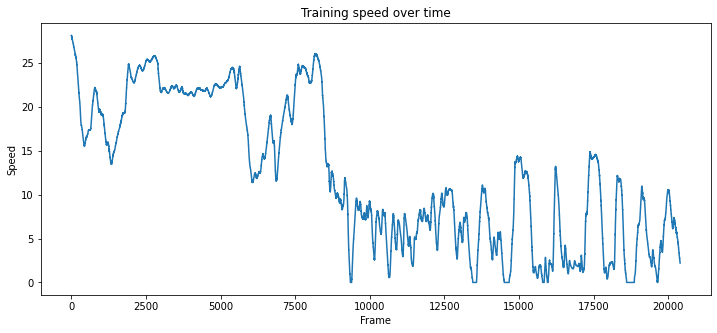

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(labels)
plt.xlabel('Frame')
plt.ylabel('Speed')
plt.title('Training speed over time')
plt.show()

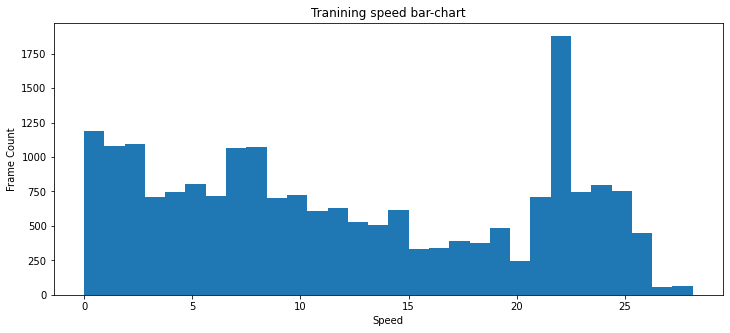

In [15]:
plt.figure(figsize=(12, 5))
plt.hist(labels, bins=30)
plt.xlabel('Speed')
plt.ylabel('Frame Count')
plt.title('Tranining speed bar-chart')
plt.show()

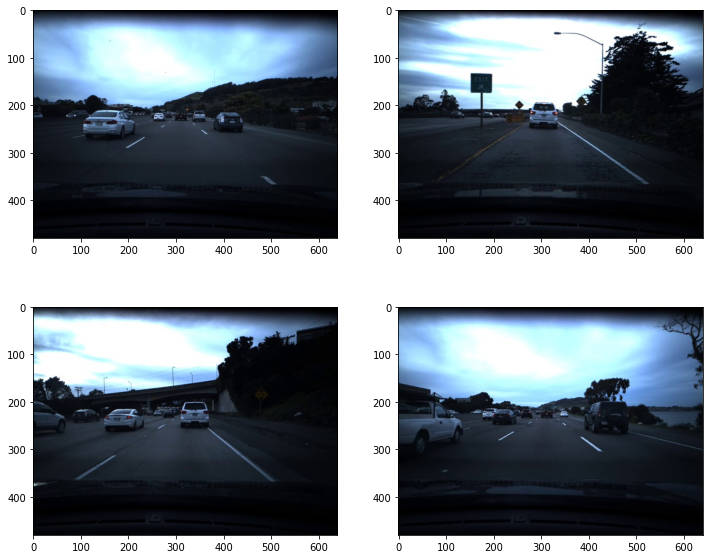

In [16]:
# View 4 random sample images to get understanding of data
fig = plt.figure(figsize=(12,10))

for i in range(1, 5):
    fname = random.choice(train_images_list)  
    img = plt.imread(os.path.join(TRAIN_IMG_DIR, fname))
    fig.add_subplot(2, 2, i)
    plt.imshow(img)
plt.show()

The images are all the same size (480X640), we may want to scale these down. We may want to also trim the edges, especially the car interior at the top and bottom, if there is no valuable data there.

The images are darker than we would like so we will need to look at increasing the brightnesss/saturation to get more valuable data.